# Assignment 3 - Variational Autoencoders
## DS552 - Generative AI
**Matt Zujewski**

This notebook implements and explores VAEs through three main tasks:
1. Convolutional VAE on CIFAR-10
2. Latent space interpolation
3. Training on CelebA dataset

**Note:** Training was run for 10 epochs each (CIFAR-10 and CelebA) on MacBook Pro M2 with Metal GPU acceleration. Total runtime was approximately 30 minutes.

---

## Theory Questions

### Q1: Why is the KL Divergence term important in the VAE loss function?

KL divergence regularizes the latent space by penalizing deviation from N(0,1). Without it, the encoder just maps inputs to arbitrary points with no structure - you end up with islands of valid encodings separated by gaps where the decoder hasn't learned anything useful. This means you can't sample coherently or interpolate between points.

The trade-off is that too much KL weight over-constrains the latent space and you get blurry reconstructions. The model is forced to compress everything toward the prior, which limits how much information can actually be encoded.

### Q2: How does the reparameterization trick enable backpropagation through the stochastic layers of a VAE?

You can't backprop through sampling - if z is sampled directly from N(μ, σ²), there's no gradient path back to μ and σ. The trick is to sample ε ~ N(0,1) separately and compute z = μ + σ·ε. Now the stochasticity is isolated in ε (which doesn't need gradients), and μ and σ are deterministic operations that gradients can flow through.

The downside is this only works cleanly for distributions with simple reparameterizations. Discrete latent variables or more complex distributions need different approaches like REINFORCE, which have much higher variance.

### Q3: Why does a VAE use a probabilistic latent space instead of a fixed latent space?

Fixed latent codes (standard autoencoders) are brittle - the decoder only learns to handle the exact points it sees during training. Probabilistic encodings force the decoder to handle noise around each point, which makes the latent space continuous and smooth enough for sampling.

The cost is computational - you're sampling during both training and inference, and the KL term adds overhead. For pure reconstruction tasks, regular autoencoders are simpler and often better.

### Q4: What role does KL Divergence play in ensuring a smooth latent space?

Without KL divergence, encodings can form disconnected clusters - think different object classes mapped to completely separate regions with empty space between them. KL forces overlap by constraining everything toward N(0,1), which means the decoder has to learn smooth transitions across the whole space instead of just memorizing specific islands. If you turn off KL entirely, interpolation gives you nonsense in the gaps.

---

## Setup and Imports

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Set device - using MPS (Metal) for M2 GPU acceleration
# Falls back to CPU if Metal isn't available
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
print(f"Using device: {device}")

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

Using device: mps


---
## Task 1: Convolutional VAE on CIFAR-10

I'll build a VAE with convolutional layers to better capture spatial relationships in images. This should give much better results than a fully connected architecture.

Architecture uses strided convolutions instead of pooling to keep things simple, though this does make the decoder slightly harder to tune since transposed convs can create checkerboard artifacts.

### Model Architecture

In [2]:
class ConvVAE(nn.Module):
    """
    Convolutional Variational Autoencoder for CIFAR-10
    
    Architecture uses conv layers to preserve spatial information,
    which should give better results than fully connected layers
    for image generation.
    """
    
    def __init__(self, latent_dim=128):
        super(ConvVAE, self).__init__()
        self.latent_dim = latent_dim
        
        # Encoder - progressively downsample spatial dimensions
        # CIFAR-10 is 32x32x3, we'll go 32 -> 16 -> 8 -> 4 -> 2
        self.encoder = nn.Sequential(
            # 32x32x3 -> 16x16x64
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            
            # 16x16x64 -> 8x8x128
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            
            # 8x8x128 -> 4x4x256
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            
            # 4x4x256 -> 2x2x512
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
        )
        
        # Latent space parameters
        # After encoder: 2x2x512 = 2048 features
        self.fc_mu = nn.Linear(2048, latent_dim)
        self.fc_logvar = nn.Linear(2048, latent_dim)
        
        # Decoder input
        self.fc_decode = nn.Linear(latent_dim, 2048)
        
        # Decoder - mirror the encoder with transposed convolutions
        self.decoder = nn.Sequential(
            # 2x2x512 -> 4x4x256
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            
            # 4x4x256 -> 8x8x128
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            
            # 8x8x128 -> 16x16x64
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            
            # 16x16x64 -> 32x32x3
            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()  # Output in [0,1] range
        )
    
    def encode(self, x):
        """Encode input to latent parameters"""
        h = self.encoder(x)
        h = h.view(h.size(0), -1)  # Flatten
        return self.fc_mu(h), self.fc_logvar(h)
    
    def reparameterize(self, mu, logvar):
        """
        Reparameterization trick: z = mu + sigma * epsilon
        This keeps the sampling differentiable for backprop
        """
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z):
        """Decode latent vector to image"""
        h = self.fc_decode(z)
        h = h.view(h.size(0), 512, 2, 2)  # Reshape for conv layers
        return self.decoder(h)
    
    def forward(self, x):
        """Full forward pass through VAE"""
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


class FCVAE(nn.Module):
    """
    Fully Connected VAE for comparison
    
    This is the baseline - no conv layers, just flatten and dense.
    Should show worse spatial coherence than ConvVAE.
    """
    
    def __init__(self, latent_dim=128):
        super(FCVAE, self).__init__()
        self.latent_dim = latent_dim
        
        # Encoder - just flatten and dense layers
        # CIFAR-10: 32x32x3 = 3072 input features
        self.fc1 = nn.Linear(3072, 512)
        self.fc2 = nn.Linear(512, 256)
        
        self.fc_mu = nn.Linear(256, latent_dim)
        self.fc_logvar = nn.Linear(256, latent_dim)
        
        # Decoder
        self.fc3 = nn.Linear(latent_dim, 256)
        self.fc4 = nn.Linear(256, 512)
        self.fc5 = nn.Linear(512, 3072)
    
    def encode(self, x):
        h = x.view(x.size(0), -1)  # Flatten immediately
        h = F.relu(self.fc1(h))
        h = F.relu(self.fc2(h))
        return self.fc_mu(h), self.fc_logvar(h)
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z):
        h = F.relu(self.fc3(z))
        h = F.relu(self.fc4(h))
        h = torch.sigmoid(self.fc5(h))
        return h.view(h.size(0), 3, 32, 32)  # Reshape back to image
    
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


def vae_loss(recon_x, x, mu, logvar, beta=1.0):
    """
    VAE loss = Reconstruction + KL Divergence
    
    Reconstruction loss measures how well we recreate the input
    KL divergence regularizes the latent space to be close to N(0,1)
    
    Beta parameter allows for beta-VAE weighting if needed
    """
    # Reconstruction loss - binary cross entropy works well for normalized images
    recon_loss = F.binary_cross_entropy(recon_x, x, reduction='sum')
    
    # KL divergence: -0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
    return recon_loss + beta * kl_loss, recon_loss, kl_loss

### Load CIFAR-10 Dataset

Loading CIFAR-10 dataset...
Training samples: 50000
Test samples: 10000


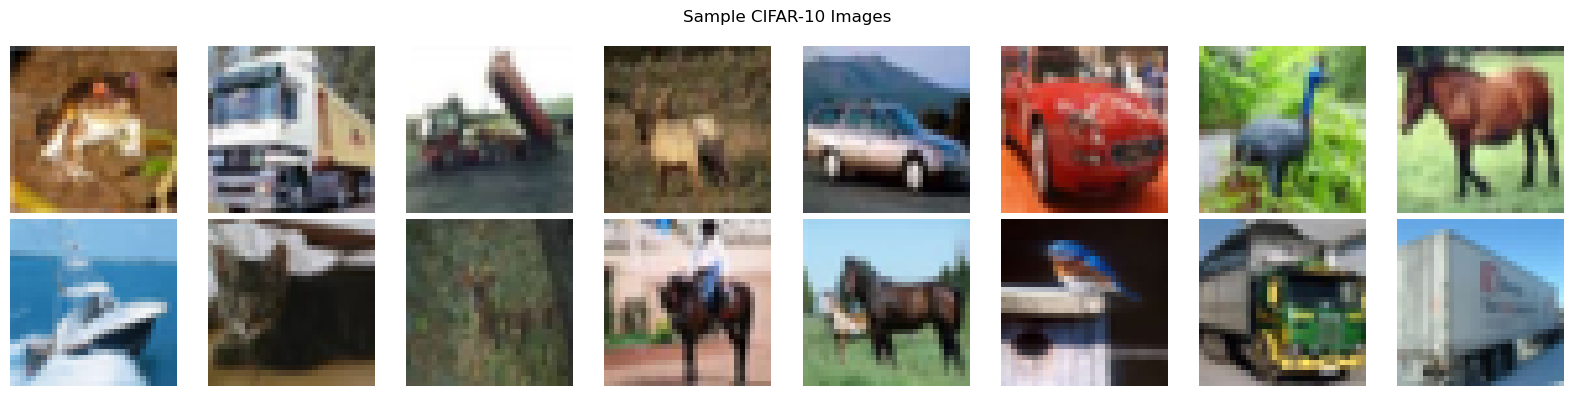

In [3]:
# Data preprocessing
transform = transforms.Compose([
    transforms.ToTensor(),
    # No normalization - keep in [0,1] for BCE loss
])

print("Loading CIFAR-10 dataset...")
train_dataset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform
)
test_dataset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform
)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=2)

print(f"Training samples: {len(train_dataset)}")
print(f"Test samples: {len(test_dataset)}")

# Visualize some training samples
fig, axes = plt.subplots(2, 8, figsize=(16, 4))
for i in range(16):
    img, _ = train_dataset[i]
    ax = axes[i // 8, i % 8]
    ax.imshow(img.permute(1, 2, 0).numpy())
    ax.axis('off')
plt.suptitle('Sample CIFAR-10 Images')
plt.tight_layout()
plt.show()

### Initialize Model and Optimizer

In [4]:
latent_dim = 128
model = ConvVAE(latent_dim=latent_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

print(f"Model architecture:")
print(f"Latent dimension: {latent_dim}")
print(f"Total parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"\nTraining configuration:")
print(f"  Optimizer: Adam, LR: 1e-3")
print(f"  Batch size: 128")
print(f"  Device: {device}")
print(f"  Loss: BCE reconstruction + KL divergence (β=1.0)")

Model architecture:
Latent dimension: 128
Total parameters: 6,304,131

Training configuration:
  Optimizer: Adam, LR: 1e-3
  Batch size: 128
  Device: mps
  Loss: BCE reconstruction + KL divergence (β=1.0)


### Training Loop

In [5]:
def train_epoch(model, train_loader, optimizer, beta=1.0):
    """Train for one epoch"""
    model.train()
    total_loss = 0
    total_recon = 0
    total_kl = 0
    
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        
        recon_batch, mu, logvar = model(data)
        loss, recon, kl = vae_loss(recon_batch, data, mu, logvar, beta)
        
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        total_recon += recon.item()
        total_kl += kl.item()
    
    n_samples = len(train_loader.dataset)
    return total_loss / n_samples, total_recon / n_samples, total_kl / n_samples


def validate(model, val_loader, beta=1.0):
    """Validate the model"""
    model.eval()
    total_loss = 0
    total_recon = 0
    total_kl = 0
    
    with torch.no_grad():
        for data, _ in val_loader:
            data = data.to(device)
            recon_batch, mu, logvar = model(data)
            loss, recon, kl = vae_loss(recon_batch, data, mu, logvar, beta)
            total_loss += loss.item()
            total_recon += recon.item()
            total_kl += kl.item()
    
    n_samples = len(val_loader.dataset)
    return total_loss / n_samples, total_recon / n_samples, total_kl / n_samples

In [6]:
# Training loop
num_epochs = 15 
train_losses = []
val_losses = []
train_recon_losses = []
train_kl_losses = []

print("Starting training...")
for epoch in range(num_epochs):
    train_loss, train_recon, train_kl = train_epoch(model, train_loader, optimizer)
    val_loss, val_recon, val_kl = validate(model, test_loader)
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_recon_losses.append(train_recon)
    train_kl_losses.append(train_kl)
    
    if (epoch + 1) % 5 == 0:
        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"  Train - Loss: {train_loss:.2f}, Recon: {train_recon:.2f}, KL: {train_kl:.2f}")
        print(f"  Val   - Loss: {val_loss:.2f}, Recon: {val_recon:.2f}, KL: {val_kl:.2f}")

print("\nTraining complete!")

Starting training...
Epoch 5/15
  Train - Loss: 1830.16, Recon: 1792.58, KL: 37.57
  Val   - Loss: 1830.92, Recon: 1793.53, KL: 37.38
Epoch 10/15
  Train - Loss: 1823.77, Recon: 1783.49, KL: 40.27
  Val   - Loss: 1825.58, Recon: 1785.06, KL: 40.52
Epoch 15/15
  Train - Loss: 1820.98, Recon: 1779.75, KL: 41.23
  Val   - Loss: 1822.90, Recon: 1782.25, KL: 40.65

Training complete!


### Visualize Training Progress

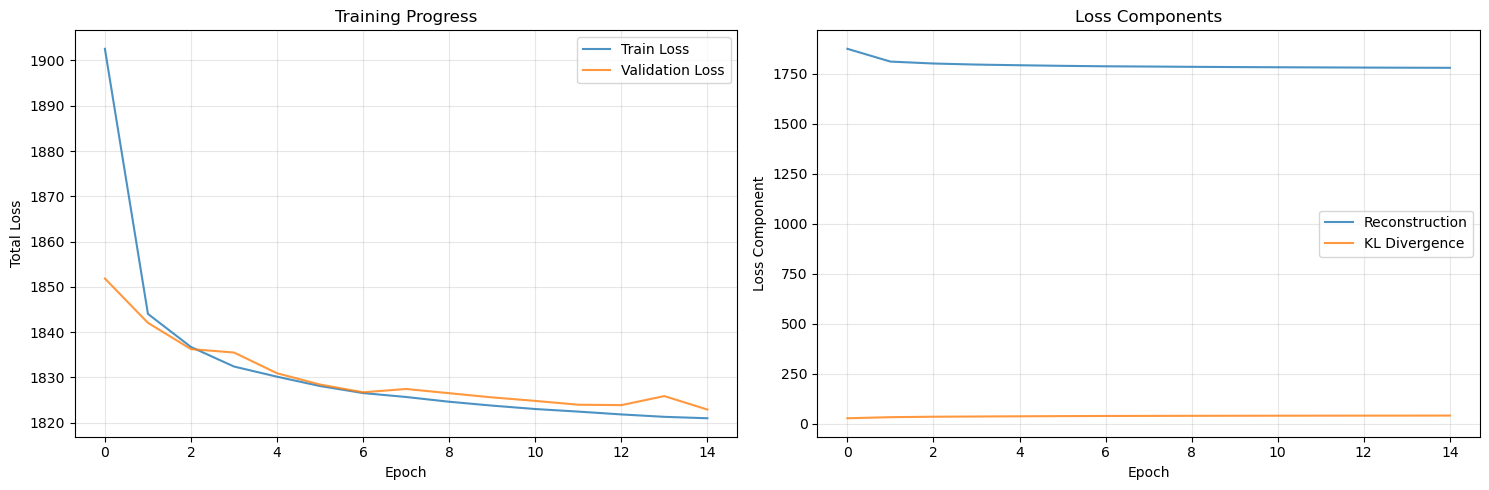

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Total loss
axes[0].plot(train_losses, label='Train Loss', alpha=0.8)
axes[0].plot(val_losses, label='Validation Loss', alpha=0.8)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Total Loss')
axes[0].set_title('Training Progress')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Component losses
axes[1].plot(train_recon_losses, label='Reconstruction', alpha=0.8)
axes[1].plot(train_kl_losses, label='KL Divergence', alpha=0.8)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss Component')
axes[1].set_title('Loss Components')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

### Generate Samples from Latent Space

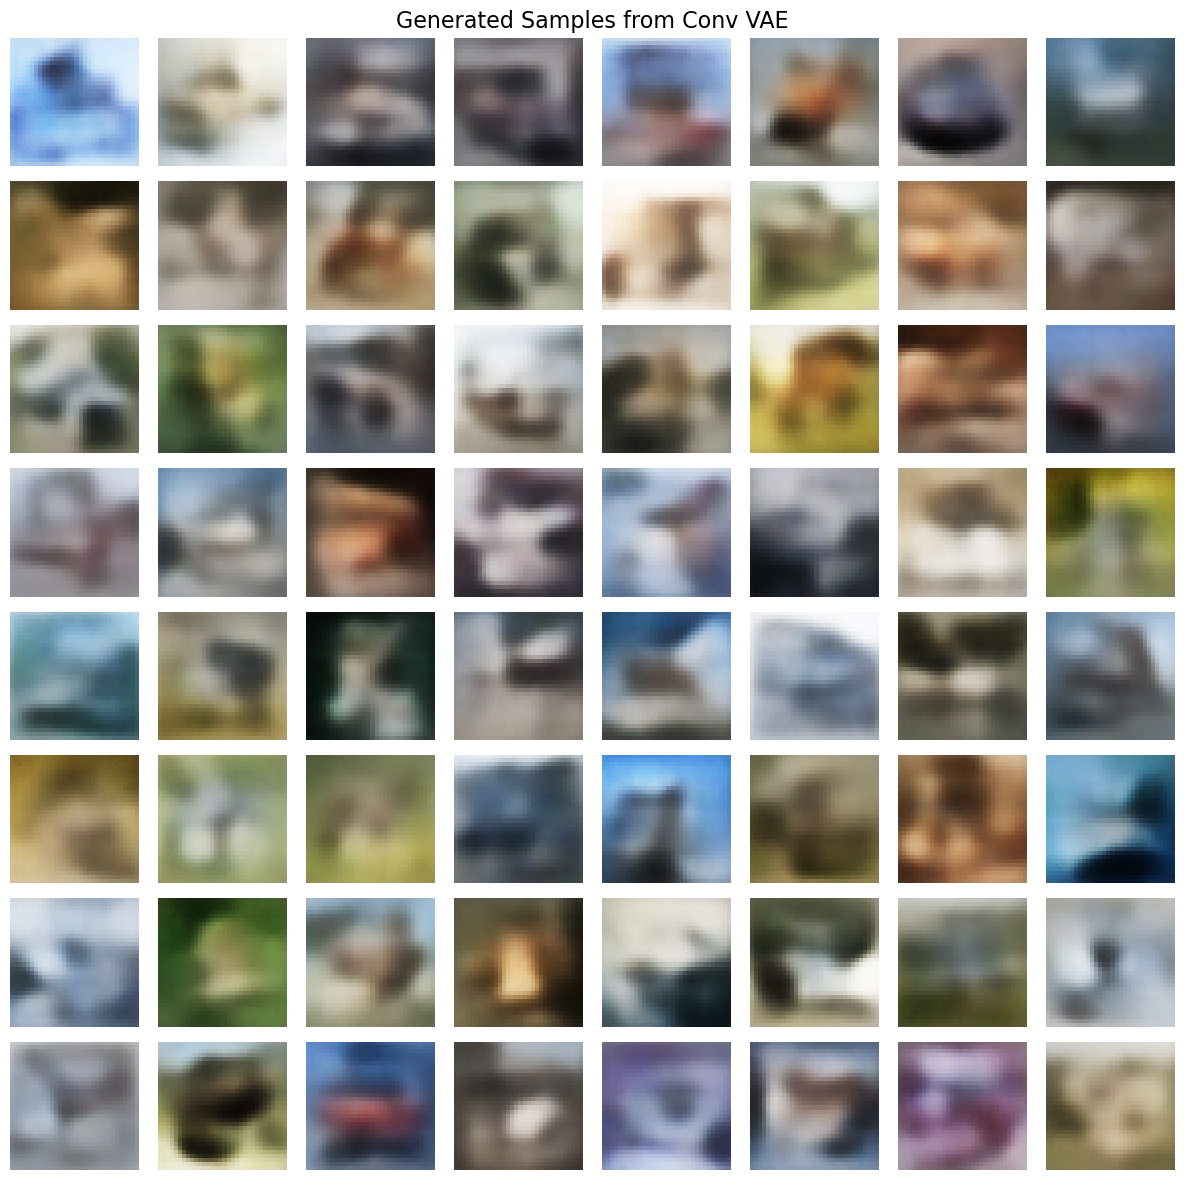

In [8]:
model.eval()
with torch.no_grad():
    # Sample from prior N(0,1)
    z = torch.randn(64, latent_dim).to(device)
    samples = model.decode(z).cpu()
    
    # Plot generated samples
    fig, axes = plt.subplots(8, 8, figsize=(12, 12))
    for i, ax in enumerate(axes.flat):
        img = samples[i].permute(1, 2, 0).numpy()
        ax.imshow(img)
        ax.axis('off')
    plt.suptitle('Generated Samples from Conv VAE', fontsize=16)
    plt.tight_layout()
    plt.show()

### Evaluate Reconstruction Quality

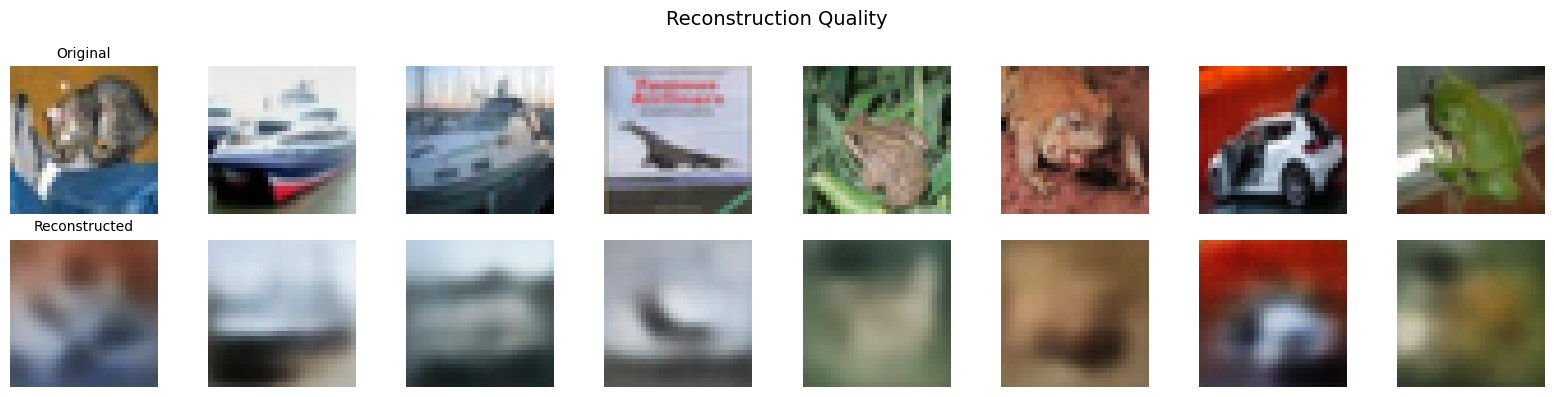

In [9]:
model.eval()
with torch.no_grad():
    test_data, _ = next(iter(test_loader))
    test_data = test_data[:8].to(device)
    recon_data, _, _ = model(test_data)
    
    fig, axes = plt.subplots(2, 8, figsize=(16, 4))
    for i in range(8):
        # Original
        axes[0, i].imshow(test_data[i].cpu().permute(1, 2, 0).numpy())
        axes[0, i].axis('off')
        if i == 0:
            axes[0, i].set_title('Original', fontsize=10)
        
        # Reconstruction
        axes[1, i].imshow(recon_data[i].cpu().permute(1, 2, 0).numpy())
        axes[1, i].axis('off')
        if i == 0:
            axes[1, i].set_title('Reconstructed', fontsize=10)
    
    plt.suptitle('Reconstruction Quality', fontsize=14)
    plt.tight_layout()
    plt.show()

### Save Model

In [10]:
# Save the trained model
torch.save({
    'model_state_dict': model.state_dict(),
    'latent_dim': latent_dim,
    'train_losses': train_losses,
    'val_losses': val_losses
}, 'conv_vae_cifar10.pth')

print("Model saved to 'conv_vae_cifar10.pth'")

Model saved to 'conv_vae_cifar10.pth'


### Fully Connected VAE Baseline (for Comparison)

To properly compare architectures, I'll train a fully connected VAE on the same data. This should show why conv layers matter for images.

In [11]:
# Train FC VAE
fc_model = FCVAE(latent_dim=latent_dim).to(device)
fc_optimizer = torch.optim.Adam(fc_model.parameters(), lr=1e-3)

print(f"\nFC VAE architecture:")
print(f"Total parameters: {sum(p.numel() for p in fc_model.parameters()):,}")
print("\nTraining FC VAE for 10 epochs...")

fc_train_losses = []
fc_val_losses = []

for epoch in range(10):
    train_loss, train_recon, train_kl = train_epoch(fc_model, train_loader, fc_optimizer)
    val_loss, val_recon, val_kl = validate(fc_model, test_loader)
    
    fc_train_losses.append(train_loss)
    fc_val_losses.append(val_loss)
    
    if (epoch + 1) % 5 == 0:
        print(f"Epoch {epoch+1}/10")
        print(f"  Train - Loss: {train_loss:.2f}, Recon: {train_recon:.2f}, KL: {train_kl:.2f}")
        print(f"  Val   - Loss: {val_loss:.2f}, Recon: {val_recon:.2f}, KL: {val_kl:.2f}")

print("\nFC VAE training complete!")


FC VAE architecture:
Total parameters: 3,511,040

Training FC VAE for 10 epochs...
Epoch 5/10
  Train - Loss: 1884.13, Recon: 1867.11, KL: 17.03
  Val   - Loss: 1884.98, Recon: 1868.15, KL: 16.82
Epoch 10/10
  Train - Loss: 1864.45, Recon: 1845.98, KL: 18.47
  Val   - Loss: 1867.53, Recon: 1849.33, KL: 18.20

FC VAE training complete!


### Compare Conv vs FC VAE

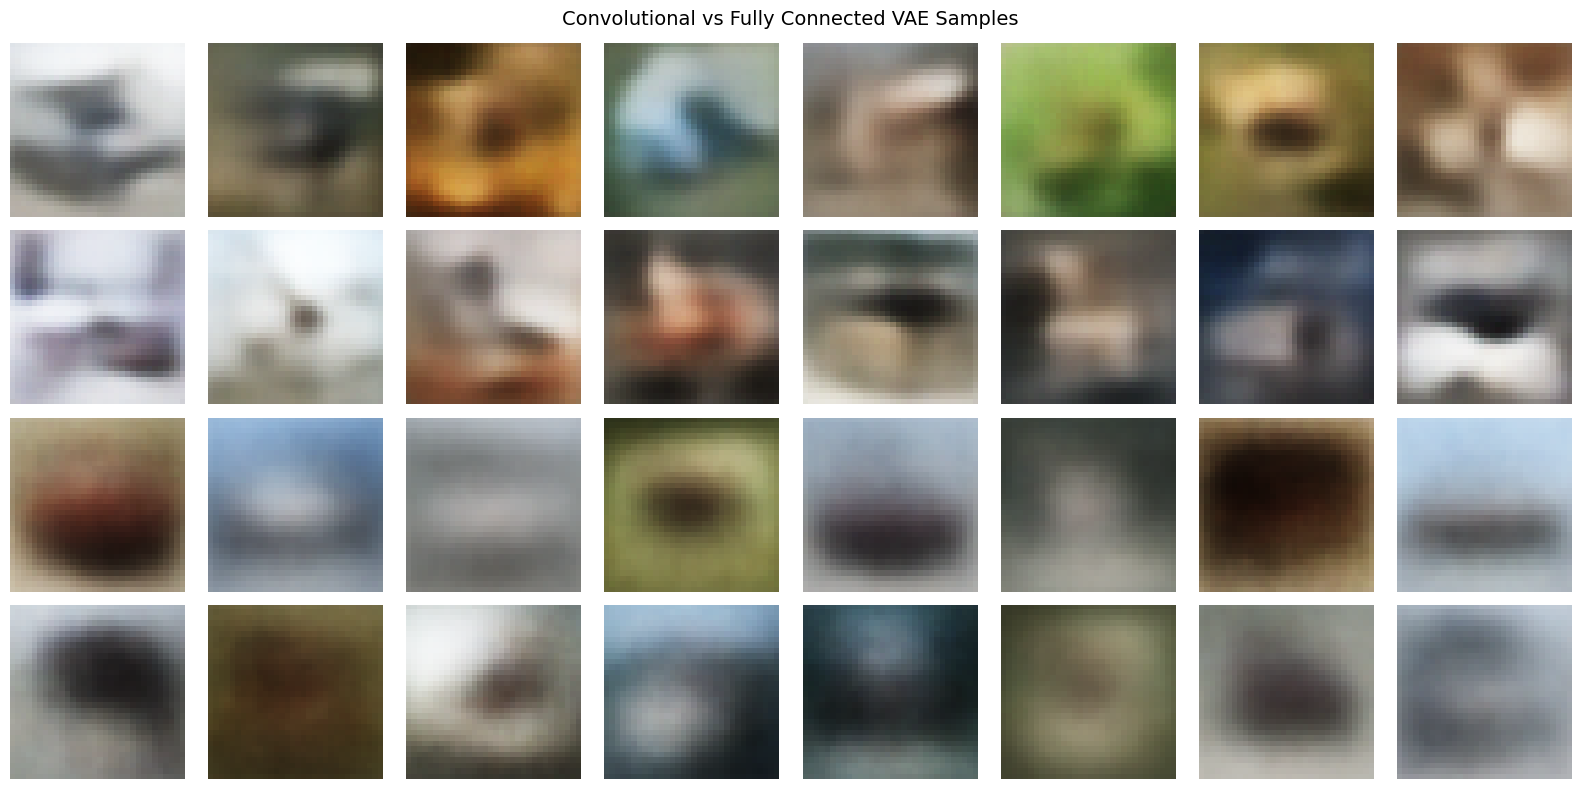


Observations:
Conv VAE: Images have better spatial coherence - objects have recognizable structure
FC VAE: Images are more scattered/noisy - no exploitation of spatial locality

The FC VAE treats pixels as independent features, so it loses spatial relationships.
Conv layers preserve these relationships through local receptive fields, which is why
the generated images look more like actual objects rather than random pixel collections.


In [12]:
# Generate samples from both models
model.eval()
fc_model.eval()

with torch.no_grad():
    z = torch.randn(16, latent_dim).to(device)
    conv_samples = model.decode(z).cpu()
    fc_samples = fc_model.decode(z).cpu()

# Side-by-side comparison
fig, axes = plt.subplots(4, 8, figsize=(16, 8))

for i in range(16):
    # Conv samples (top two rows)
    ax = axes[i // 8, i % 8]
    ax.imshow(conv_samples[i].permute(1, 2, 0).numpy())
    ax.axis('off')
    if i == 0:
        ax.set_ylabel('Conv VAE', fontsize=12)
    
    # FC samples (bottom two rows)
    ax = axes[2 + i // 8, i % 8]
    ax.imshow(fc_samples[i].permute(1, 2, 0).numpy())
    ax.axis('off')
    if i == 0:
        ax.set_ylabel('FC VAE', fontsize=12)

plt.suptitle('Convolutional vs Fully Connected VAE Samples', fontsize=14)
plt.tight_layout()
plt.show()

print("\nObservations:")
print("Conv VAE: Images have better spatial coherence - objects have recognizable structure")
print("FC VAE: Images are more scattered/noisy - no exploitation of spatial locality")
print("\nThe FC VAE treats pixels as independent features, so it loses spatial relationships.")
print("Conv layers preserve these relationships through local receptive fields, which is why")
print("the generated images look more like actual objects rather than random pixel collections.")

---
## Task 2: Latent Space Interpolation

Now I'll explore the latent space by interpolating between images. This demonstrates how smooth and continuous the learned representations are.

### Linear Interpolation Between Image Pairs

In [13]:
def interpolate_latent(model, img1, img2, num_steps=10):
    """
    Interpolate between two images in latent space
    
    The idea here is to encode both images to get their latent representations,
    then create a smooth path between them by linear interpolation.
    Since VAEs learn continuous latent spaces, this should give us
    smooth transitions rather than abrupt changes.
    """
    model.eval()
    with torch.no_grad():
        # Encode both images to get latent representations
        img1 = img1.unsqueeze(0).to(device)
        img2 = img2.unsqueeze(0).to(device)
        
        mu1, logvar1 = model.encode(img1)
        mu2, logvar2 = model.encode(img2)
        
        # Use the mean of the distribution for interpolation (more stable than sampling)
        z1 = mu1
        z2 = mu2
        
        # Create interpolation weights
        alphas = np.linspace(0, 1, num_steps)
        
        interpolated_imgs = []
        for alpha in alphas:
            # Linear interpolation: z = (1-alpha)*z1 + alpha*z2
            z_interp = (1 - alpha) * z1 + alpha * z2
            
            # Decode interpolated latent vector
            img_interp = model.decode(z_interp)
            interpolated_imgs.append(img_interp.cpu())
        
        return torch.cat(interpolated_imgs, dim=0)

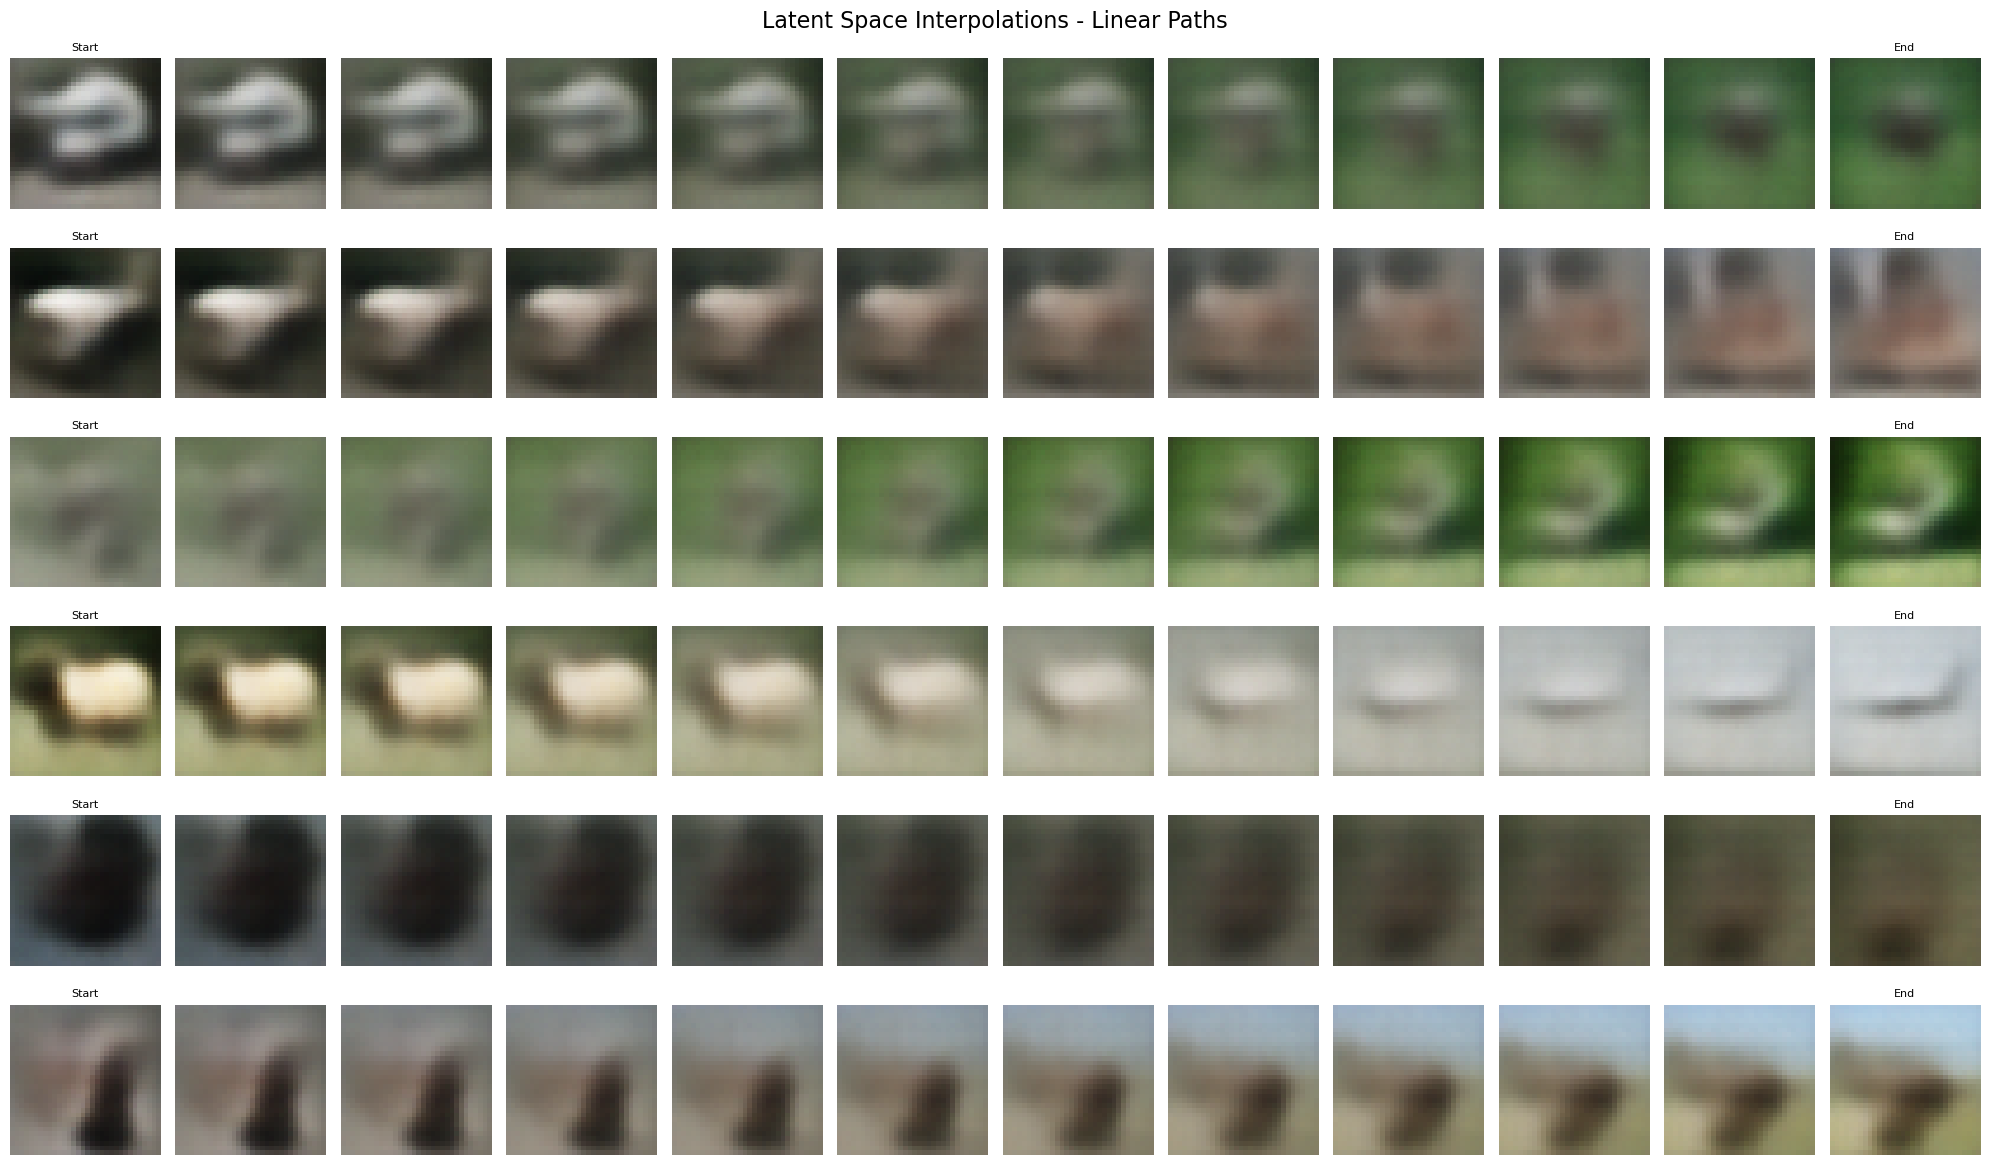

In [14]:
# Generate interpolation visualizations
num_pairs = 6
steps_per_pair = 12

fig, axes = plt.subplots(num_pairs, steps_per_pair, figsize=(20, 2*num_pairs))

for pair_idx in range(num_pairs):
    # Randomly select two different images
    idx1 = np.random.randint(0, len(test_dataset))
    idx2 = np.random.randint(0, len(test_dataset))
    
    img1, _ = test_dataset[idx1]
    img2, _ = test_dataset[idx2]
    
    # Generate interpolation
    interp_imgs = interpolate_latent(model, img1, img2, num_steps=steps_per_pair)
    
    # Plot the sequence
    for step_idx in range(steps_per_pair):
        ax = axes[pair_idx, step_idx]
        img = interp_imgs[step_idx].permute(1, 2, 0).numpy()
        ax.imshow(img)
        ax.axis('off')
        
        # Label endpoints
        if step_idx == 0:
            ax.set_title('Start', fontsize=8)
        elif step_idx == steps_per_pair - 1:
            ax.set_title('End', fontsize=8)

plt.suptitle('Latent Space Interpolations - Linear Paths', fontsize=16)
plt.tight_layout()
plt.show()

# Interpolation works smoothly for color and coarse shape, but fine details (edges, textures)
# tend to blur out in the middle frames. This is expected with VAEs - the reconstruction loss
# doesn't heavily penalize losing high-frequency details.

### 2D Grid Interpolation

Interpolate between 4 corner images to visualize the 2D manifold structure

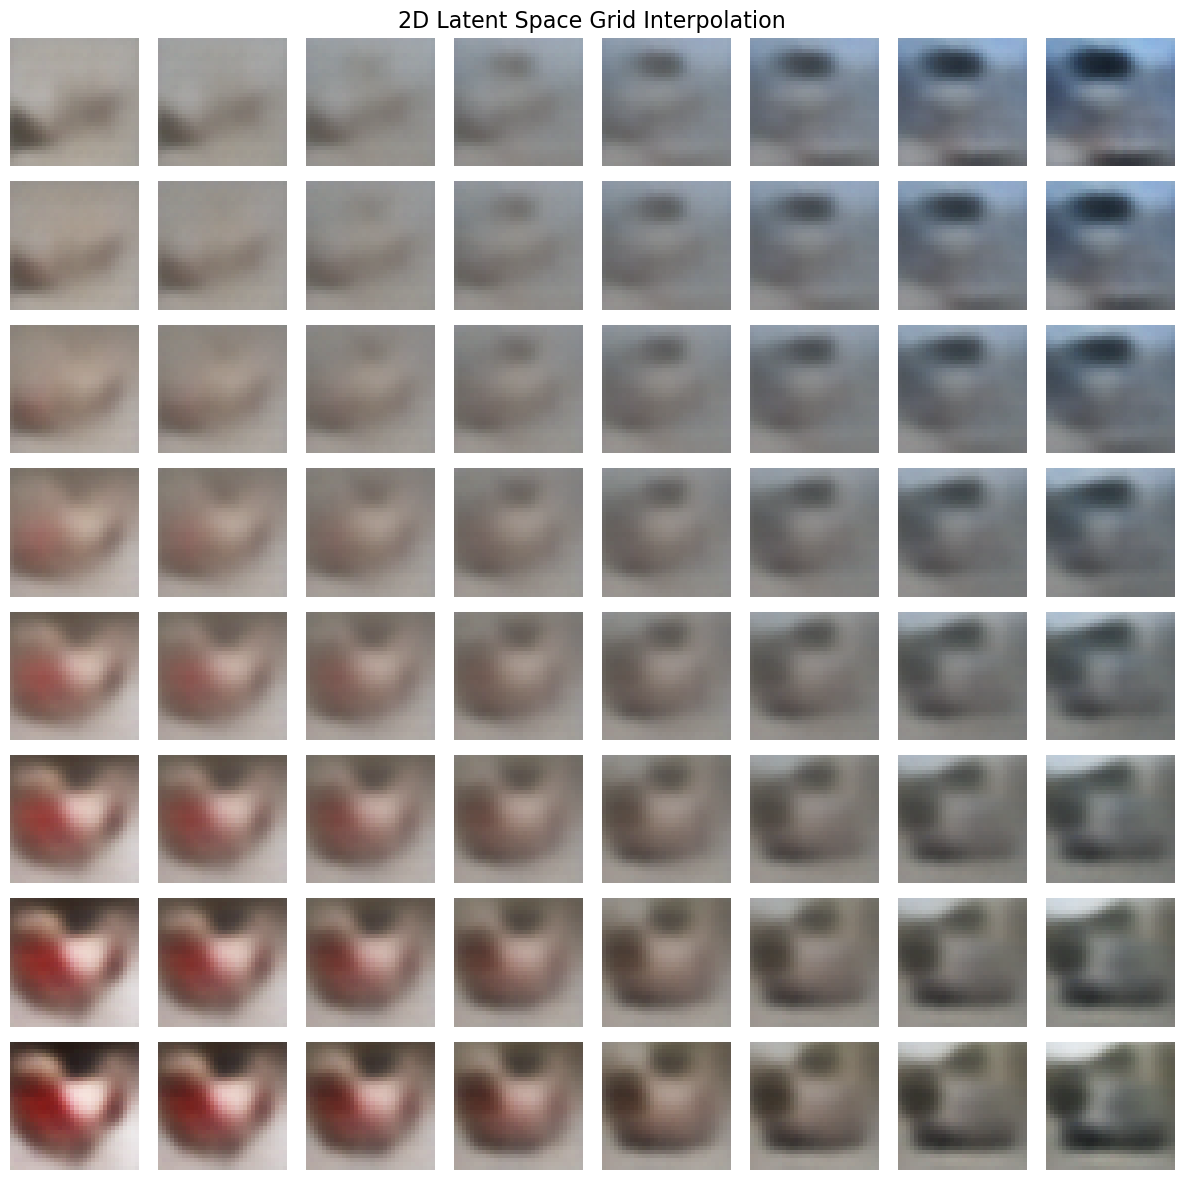

In [15]:
# Select 4 corner images
corners = []
for _ in range(4):
    idx = np.random.randint(0, len(test_dataset))
    img, _ = test_dataset[idx]
    corners.append(img)

grid_size = 8
fig, axes = plt.subplots(grid_size, grid_size, figsize=(12, 12))

model.eval()
with torch.no_grad():
    # Encode all corner images
    corner_zs = []
    for img in corners:
        img_batch = img.unsqueeze(0).to(device)
        mu, _ = model.encode(img_batch)
        corner_zs.append(mu)
    
    # Interpolate in a 2D grid
    for i in range(grid_size):
        for j in range(grid_size):
            # Weights for bilinear interpolation
            alpha_i = i / (grid_size - 1)
            alpha_j = j / (grid_size - 1)
            
            # Interpolate: top-left -> top-right -> bottom-left -> bottom-right
            z_top = (1 - alpha_j) * corner_zs[0] + alpha_j * corner_zs[1]
            z_bottom = (1 - alpha_j) * corner_zs[2] + alpha_j * corner_zs[3]
            z_interp = (1 - alpha_i) * z_top + alpha_i * z_bottom
            
            # Decode and display
            img_decoded = model.decode(z_interp).cpu()
            axes[i, j].imshow(img_decoded[0].permute(1, 2, 0).numpy())
            axes[i, j].axis('off')

plt.suptitle('2D Latent Space Grid Interpolation', fontsize=16)
plt.tight_layout()
plt.show()

### Quantitative Smoothness Analysis

Interpolation Smoothness Analysis:
Average frame-to-frame difference: 0.000583
Std deviation: 0.000372

Lower values indicate smoother transitions in latent space


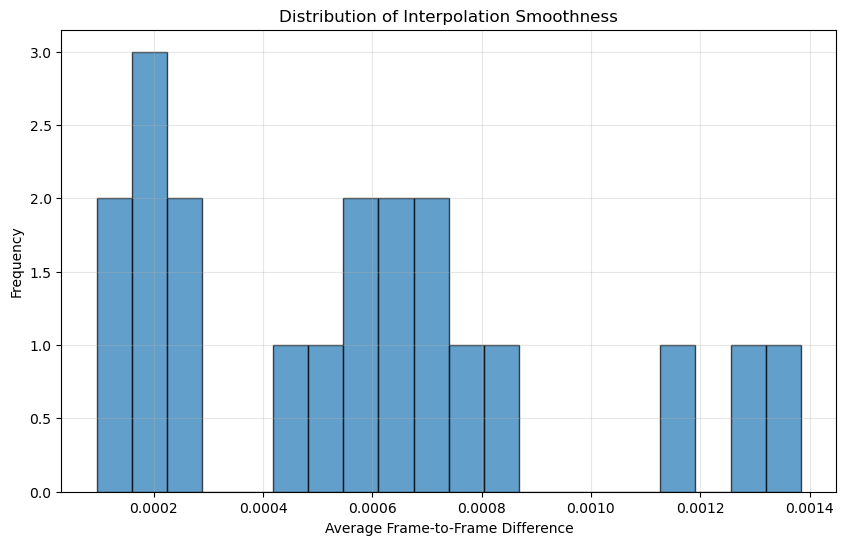

In [16]:
# Analyze interpolation smoothness
num_samples = 20
steps = 15

smoothness_scores = []

for _ in range(num_samples):
    idx1 = np.random.randint(0, len(test_dataset))
    idx2 = np.random.randint(0, len(test_dataset))
    
    img1, _ = test_dataset[idx1]
    img2, _ = test_dataset[idx2]
    
    interp_imgs = interpolate_latent(model, img1, img2, num_steps=steps)
    
    # Calculate differences between consecutive frames
    diffs = []
    for i in range(len(interp_imgs) - 1):
        diff = torch.mean((interp_imgs[i] - interp_imgs[i+1])**2).item()
        diffs.append(diff)
    
    smoothness_scores.append(np.mean(diffs))

print(f"Interpolation Smoothness Analysis:")
print(f"Average frame-to-frame difference: {np.mean(smoothness_scores):.6f}")
print(f"Std deviation: {np.std(smoothness_scores):.6f}")
print("\nLower values indicate smoother transitions in latent space")

# Plot distribution
plt.figure(figsize=(10, 6))
plt.hist(smoothness_scores, bins=20, edgecolor='black', alpha=0.7)
plt.xlabel('Average Frame-to-Frame Difference')
plt.ylabel('Frequency')
plt.title('Distribution of Interpolation Smoothness')
plt.grid(alpha=0.3)
plt.show()

---
## Task 3: Train VAE on CelebA Dataset

Now I'll apply the same approach to a different dataset - celebrity faces. This will show how the architecture generalizes to different data distributions.

### Modified Architecture for Higher Resolution

In [17]:
class CelebAVAE(nn.Module):
    """
    Modified VAE for 64x64 CelebA images
    Uses one more layer than CIFAR-10 version to handle larger resolution
    """
    
    def __init__(self, latent_dim=256):
        super(CelebAVAE, self).__init__()
        self.latent_dim = latent_dim
        
        # Encoder: 64x64 -> 32 -> 16 -> 8 -> 4
        self.encoder = nn.Sequential(
            # 64x64x3 -> 32x32x64
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            
            # 32x32x64 -> 16x16x128
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            
            # 16x16x128 -> 8x8x256
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            
            # 8x8x256 -> 4x4x512
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),
        )
        
        # Latent parameters (4x4x512 = 8192)
        self.fc_mu = nn.Linear(8192, latent_dim)
        self.fc_logvar = nn.Linear(8192, latent_dim)
        
        self.fc_decode = nn.Linear(latent_dim, 8192)
        
        # Decoder: mirror encoder
        self.decoder = nn.Sequential(
            # 4x4x512 -> 8x8x256
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            
            # 8x8x256 -> 16x16x128
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            
            # 16x16x128 -> 32x32x64
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            
            # 32x32x64 -> 64x64x3
            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()
        )
    
    def encode(self, x):
        h = self.encoder(x)
        h = h.view(h.size(0), -1)
        return self.fc_mu(h), self.fc_logvar(h)
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z):
        h = self.fc_decode(z)
        h = h.view(h.size(0), 512, 4, 4)
        return self.decoder(h)
    
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

### Load CelebA Dataset

Loading CelebA dataset...
Note: This will download ~1.4GB if not already cached
Training samples: 162770
Validation samples: 19867


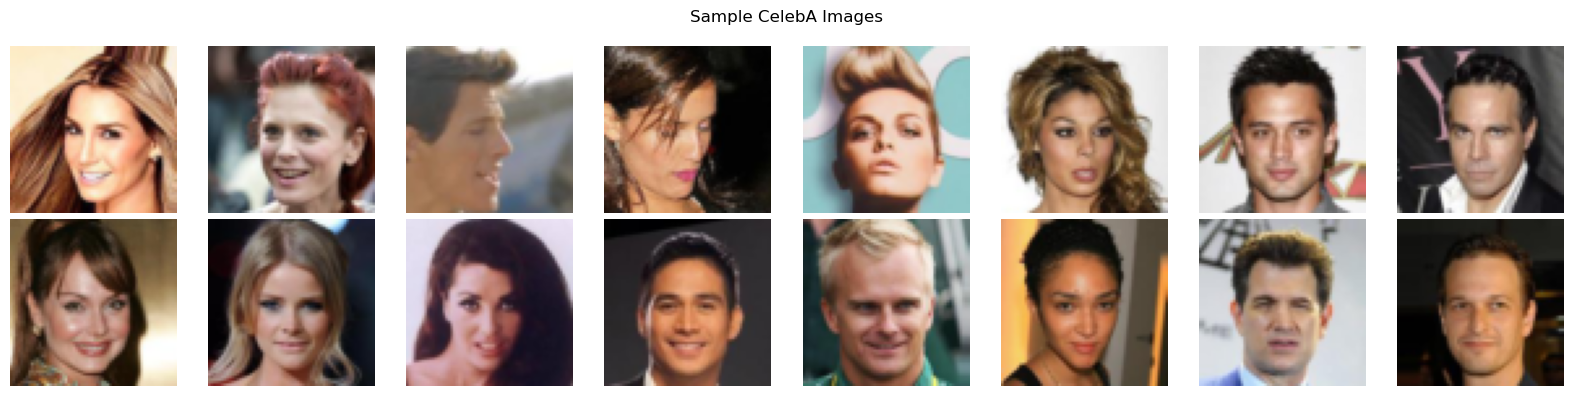

In [18]:
# CelebA preprocessing - crop to center and resize to 64x64
celeba_transform = transforms.Compose([
    transforms.CenterCrop(178),  # Remove some background
    transforms.Resize(64),
    transforms.ToTensor(),
])

print("Loading CelebA dataset...")
print("Note: This will download ~1.4GB if not already cached")

try:
    celeba_train = datasets.CelebA(
        root='./data', 
        split='train',
        download=True,
        transform=celeba_transform
    )
    celeba_val = datasets.CelebA(
        root='./data',
        split='valid',
        download=True,
        transform=celeba_transform
    )
    
    print(f"Training samples: {len(celeba_train)}")
    print(f"Validation samples: {len(celeba_val)}")
    
    # Visualize some samples
    fig, axes = plt.subplots(2, 8, figsize=(16, 4))
    for i in range(16):
        img, _ = celeba_train[i]
        ax = axes[i // 8, i % 8]
        ax.imshow(img.permute(1, 2, 0).numpy())
        ax.axis('off')
    plt.suptitle('Sample CelebA Images')
    plt.tight_layout()
    plt.show()
    
except Exception as e:
    print(f"\nError loading CelebA: {e}")
    print("\nIf download fails, you can manually download from:")
    print("https://www.kaggle.com/datasets/jessicali9530/celeba-dataset")
    print("or use the official CelebA website")
    raise

### Create Data Loaders

In [19]:
celeba_train_loader = DataLoader(
    celeba_train, 
    batch_size=64,  # Smaller batch size for larger images
    shuffle=True, 
    num_workers=4
)
celeba_val_loader = DataLoader(
    celeba_val,
    batch_size=64,
    shuffle=False,
    num_workers=4
)

### Initialize CelebA Model

In [20]:
celeba_latent_dim = 256  # Larger latent space for more complex face variations
celeba_model = CelebAVAE(latent_dim=celeba_latent_dim).to(device)
celeba_optimizer = torch.optim.Adam(celeba_model.parameters(), lr=1e-3)

print(f"CelebA VAE architecture:")
print(f"Latent dimension: {celeba_latent_dim}")
print(f"Total parameters: {sum(p.numel() for p in celeba_model.parameters()):,}")

CelebA VAE architecture:
Latent dimension: 256
Total parameters: 11,815,555


### Train CelebA VAE

In [21]:
# Training loop for CelebA
celeba_epochs = 20 
celeba_train_losses = []
celeba_val_losses = []

print("Starting CelebA training...")
for epoch in range(celeba_epochs):
    # Train
    celeba_model.train()
    epoch_loss = 0
    epoch_recon = 0
    epoch_kl = 0
    
    for batch_idx, (data, _) in enumerate(tqdm(celeba_train_loader, desc=f'Epoch {epoch+1}/{celeba_epochs}')):
        data = data.to(device)
        celeba_optimizer.zero_grad()
        
        recon_batch, mu, logvar = celeba_model(data)
        loss, recon, kl = vae_loss(recon_batch, data, mu, logvar, beta=1.0)
        
        loss.backward()
        celeba_optimizer.step()
        
        epoch_loss += loss.item()
        epoch_recon += recon.item()
        epoch_kl += kl.item()
    
    # Validation
    celeba_model.eval()
    val_loss = 0
    val_recon = 0
    val_kl = 0
    
    with torch.no_grad():
        for data, _ in celeba_val_loader:
            data = data.to(device)
            recon_batch, mu, logvar = celeba_model(data)
            loss, recon, kl = vae_loss(recon_batch, data, mu, logvar, beta=1.0)
            val_loss += loss.item()
            val_recon += recon.item()
            val_kl += kl.item()
    
    # Track metrics
    n_train = len(celeba_train_loader.dataset)
    n_val = len(celeba_val_loader.dataset)
    
    celeba_train_losses.append(epoch_loss / n_train)
    celeba_val_losses.append(val_loss / n_val)
    
    print(f"Epoch {epoch+1}/{celeba_epochs}")
    print(f"  Train - Loss: {epoch_loss/n_train:.2f}, Recon: {epoch_recon/n_train:.2f}, KL: {epoch_kl/n_train:.2f}")
    print(f"  Val   - Loss: {val_loss/n_val:.2f}, Recon: {val_recon/n_val:.2f}, KL: {val_kl/n_val:.2f}")

print("\nCelebA training complete!")

Starting CelebA training...


Epoch 1/20: 100%|███████████████████████████████| 2544/2544 [01:27<00:00, 29.19it/s]


Epoch 1/20
  Train - Loss: 6479.21, Recon: 6362.37, KL: 116.84
  Val   - Loss: 6432.41, Recon: 6322.11, KL: 110.30


Epoch 2/20: 100%|███████████████████████████████| 2544/2544 [01:24<00:00, 30.22it/s]


Epoch 2/20
  Train - Loss: 6346.25, Recon: 6232.46, KL: 113.79
  Val   - Loss: 6356.40, Recon: 6241.51, KL: 114.89


Epoch 3/20: 100%|███████████████████████████████| 2544/2544 [01:24<00:00, 30.25it/s]


Epoch 3/20
  Train - Loss: 6324.64, Recon: 6208.35, KL: 116.29
  Val   - Loss: 6343.95, Recon: 6228.76, KL: 115.19


Epoch 4/20: 100%|███████████████████████████████| 2544/2544 [02:46<00:00, 15.28it/s]


Epoch 4/20
  Train - Loss: 6312.77, Recon: 6194.59, KL: 118.18
  Val   - Loss: 6330.68, Recon: 6212.34, KL: 118.34


Epoch 5/20: 100%|███████████████████████████████| 2544/2544 [01:24<00:00, 30.21it/s]


Epoch 5/20
  Train - Loss: 6305.68, Recon: 6186.49, KL: 119.20
  Val   - Loss: 6330.39, Recon: 6213.35, KL: 117.03


Epoch 6/20: 100%|███████████████████████████████| 2544/2544 [01:24<00:00, 30.25it/s]


Epoch 6/20
  Train - Loss: 6300.41, Recon: 6180.69, KL: 119.71
  Val   - Loss: 6328.21, Recon: 6212.03, KL: 116.17


Epoch 7/20: 100%|███████████████████████████████| 2544/2544 [01:24<00:00, 30.23it/s]


Epoch 7/20
  Train - Loss: 6297.31, Recon: 6177.25, KL: 120.06
  Val   - Loss: 6323.99, Recon: 6204.16, KL: 119.83


Epoch 8/20: 100%|███████████████████████████████| 2544/2544 [01:24<00:00, 30.23it/s]


Epoch 8/20
  Train - Loss: 6293.94, Recon: 6173.71, KL: 120.23
  Val   - Loss: 6320.19, Recon: 6199.89, KL: 120.30


Epoch 9/20: 100%|███████████████████████████████| 2544/2544 [01:24<00:00, 30.12it/s]


Epoch 9/20
  Train - Loss: 6291.63, Recon: 6171.20, KL: 120.43
  Val   - Loss: 6317.99, Recon: 6199.45, KL: 118.54


Epoch 10/20: 100%|██████████████████████████████| 2544/2544 [01:24<00:00, 30.27it/s]


Epoch 10/20
  Train - Loss: 6289.59, Recon: 6169.09, KL: 120.49
  Val   - Loss: 6317.04, Recon: 6198.12, KL: 118.93


Epoch 11/20: 100%|██████████████████████████████| 2544/2544 [01:24<00:00, 30.23it/s]


Epoch 11/20
  Train - Loss: 6288.07, Recon: 6167.47, KL: 120.60
  Val   - Loss: 6316.36, Recon: 6193.90, KL: 122.46


Epoch 12/20: 100%|██████████████████████████████| 2544/2544 [01:56<00:00, 21.75it/s]


Epoch 12/20
  Train - Loss: 6286.43, Recon: 6165.78, KL: 120.65
  Val   - Loss: 6314.78, Recon: 6193.65, KL: 121.13


Epoch 13/20: 100%|██████████████████████████████| 2544/2544 [09:50<00:00,  4.31it/s]


Epoch 13/20
  Train - Loss: 6285.41, Recon: 6164.66, KL: 120.74
  Val   - Loss: 6311.74, Recon: 6192.31, KL: 119.43


Epoch 14/20: 100%|██████████████████████████████| 2544/2544 [07:41<00:00,  5.51it/s]


Epoch 14/20
  Train - Loss: 6284.14, Recon: 6163.39, KL: 120.75
  Val   - Loss: 6311.79, Recon: 6193.58, KL: 118.21


Epoch 15/20: 100%|██████████████████████████████| 2544/2544 [02:34<00:00, 16.50it/s]


Epoch 15/20
  Train - Loss: 6283.15, Recon: 6162.39, KL: 120.75
  Val   - Loss: 6310.58, Recon: 6189.52, KL: 121.06


Epoch 16/20: 100%|██████████████████████████████| 2544/2544 [01:24<00:00, 30.24it/s]


Epoch 16/20
  Train - Loss: 6282.13, Recon: 6161.39, KL: 120.74
  Val   - Loss: 6309.30, Recon: 6191.09, KL: 118.21


Epoch 17/20: 100%|██████████████████████████████| 2544/2544 [01:24<00:00, 30.07it/s]


Epoch 17/20
  Train - Loss: 6281.13, Recon: 6160.39, KL: 120.74
  Val   - Loss: 6308.90, Recon: 6189.04, KL: 119.85


Epoch 18/20: 100%|██████████████████████████████| 2544/2544 [01:24<00:00, 30.25it/s]


Epoch 18/20
  Train - Loss: 6280.56, Recon: 6159.83, KL: 120.74
  Val   - Loss: 6307.77, Recon: 6188.97, KL: 118.80


Epoch 19/20: 100%|██████████████████████████████| 2544/2544 [01:24<00:00, 30.24it/s]


Epoch 19/20
  Train - Loss: 6279.73, Recon: 6159.04, KL: 120.70
  Val   - Loss: 6310.88, Recon: 6190.69, KL: 120.18


Epoch 20/20: 100%|██████████████████████████████| 2544/2544 [01:24<00:00, 30.24it/s]


Epoch 20/20
  Train - Loss: 6279.19, Recon: 6158.50, KL: 120.69
  Val   - Loss: 6308.63, Recon: 6190.21, KL: 118.43

CelebA training complete!


### CelebA Training Progress

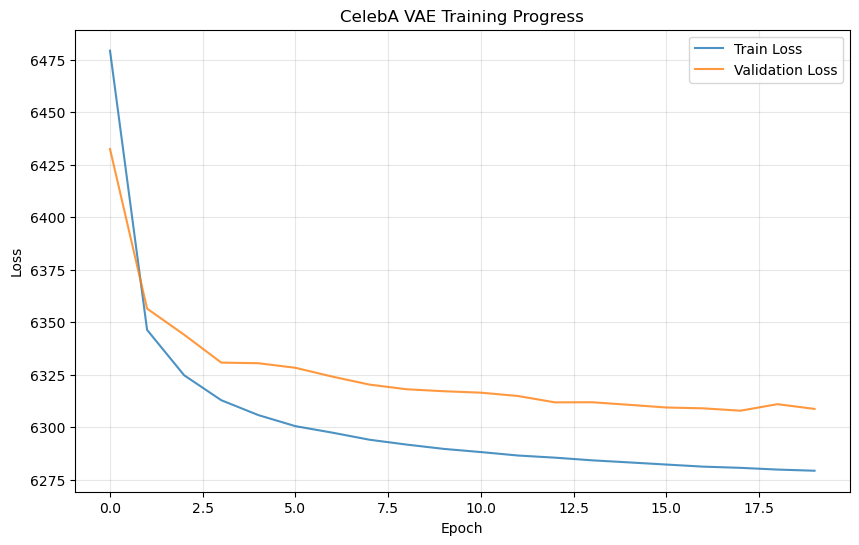

In [22]:
plt.figure(figsize=(10, 6))
plt.plot(celeba_train_losses, label='Train Loss', alpha=0.8)
plt.plot(celeba_val_losses, label='Validation Loss', alpha=0.8)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('CelebA VAE Training Progress')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

### Generate CelebA Faces

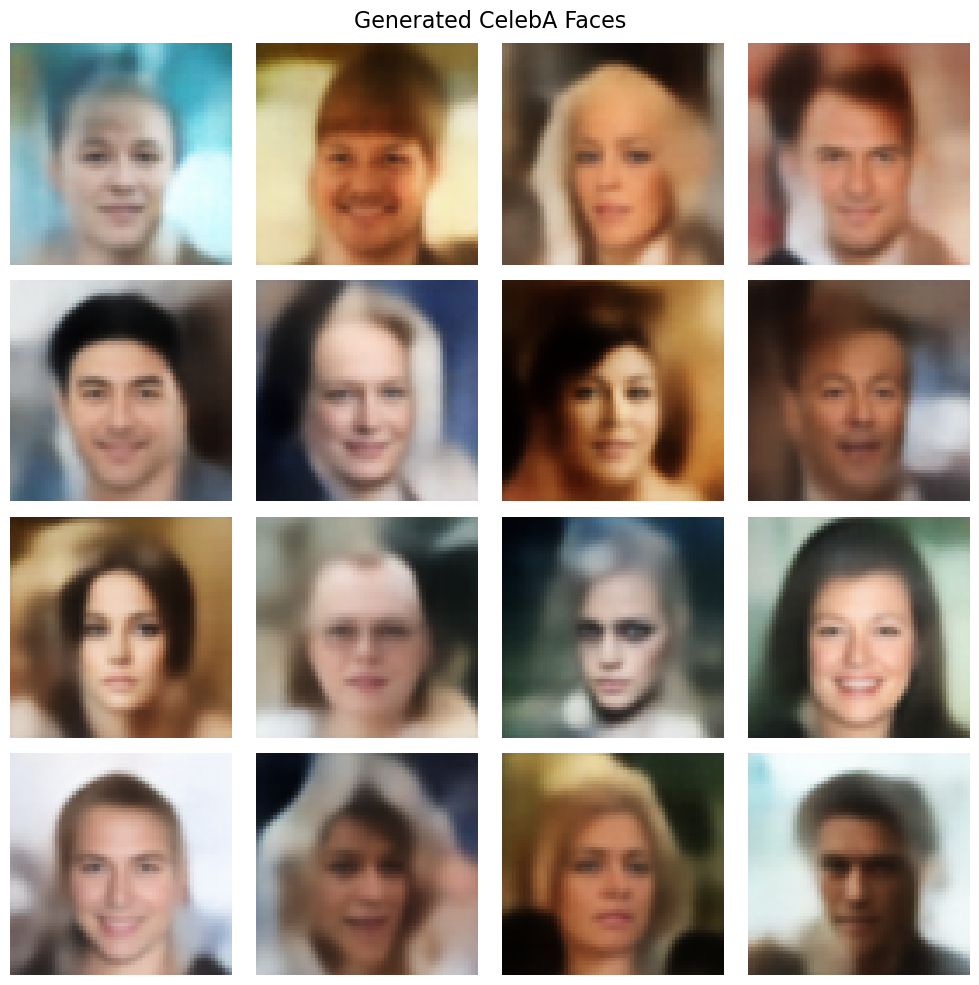

In [23]:
celeba_model.eval()
with torch.no_grad():
    z = torch.randn(16, celeba_latent_dim).to(device)
    samples = celeba_model.decode(z).cpu()
    
    fig, axes = plt.subplots(4, 4, figsize=(10, 10))
    for i, ax in enumerate(axes.flat):
        img = samples[i].permute(1, 2, 0).numpy()
        ax.imshow(img)
        ax.axis('off')
    plt.suptitle('Generated CelebA Faces', fontsize=16)
    plt.tight_layout()
    plt.show()

### CelebA Reconstruction Quality

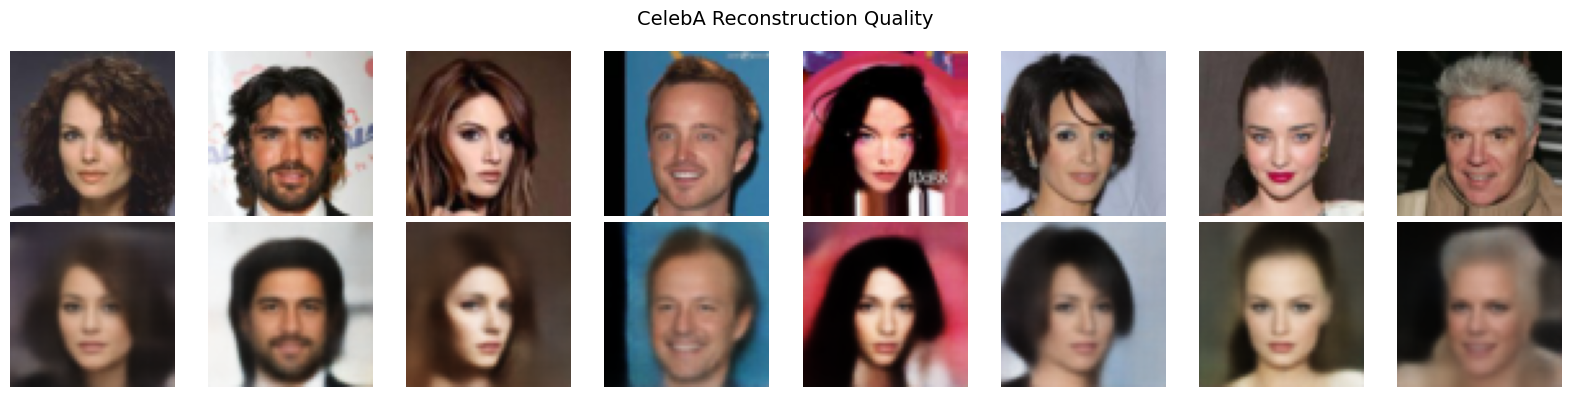

In [24]:
celeba_model.eval()
with torch.no_grad():
    val_data, _ = next(iter(celeba_val_loader))
    val_data = val_data[:8].to(device)
    recon_data, _, _ = celeba_model(val_data)

fig, axes = plt.subplots(2, 8, figsize=(16, 4))
for i in range(8):
    axes[0, i].imshow(val_data[i].cpu().permute(1, 2, 0).numpy())
    axes[0, i].axis('off')
    axes[1, i].imshow(recon_data[i].cpu().permute(1, 2, 0).numpy())
    axes[1, i].axis('off')
axes[0, 0].set_ylabel('Original', fontsize=12)
axes[1, 0].set_ylabel('Reconstructed', fontsize=12)
plt.suptitle('CelebA Reconstruction Quality', fontsize=14)
plt.tight_layout()
plt.show()

### Explore Latent Space at Different Scales

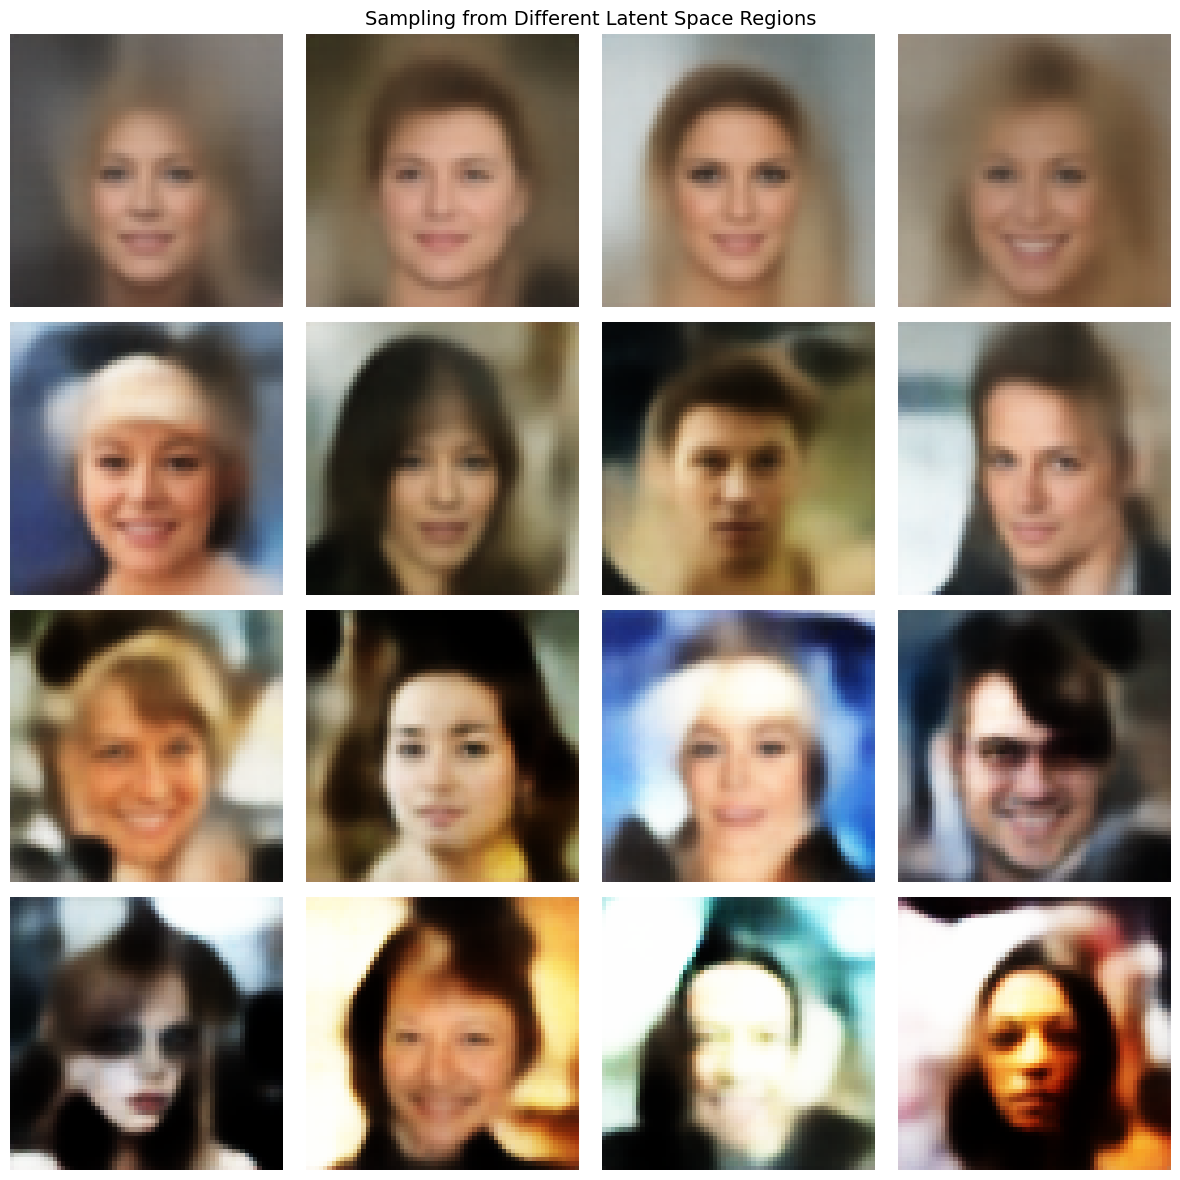

In [25]:
# Sample from different standard deviations to explore variation
celeba_model.eval()
fig, axes = plt.subplots(4, 4, figsize=(12, 12))

std_values = [0.5, 1.0, 1.5, 2.0]

for std_idx, std in enumerate(std_values):
    with torch.no_grad():
        # Sample with different spread
        z = torch.randn(4, celeba_latent_dim).to(device) * std
        samples = celeba_model.decode(z).cpu()
        
        for img_idx in range(4):
            ax = axes[std_idx, img_idx]
            img = samples[img_idx].permute(1, 2, 0).numpy()
            ax.imshow(img)
            ax.axis('off')
            if img_idx == 0:
                ax.set_ylabel(f'σ = {std}', fontsize=12)

plt.suptitle('Sampling from Different Latent Space Regions', fontsize=14)
plt.tight_layout()
plt.show()

# Sampling near the center (low σ) gives average-looking faces with less variation.
# Higher σ values add more diversity but also start distorting proportions - the model
# wasn't trained on extreme latent values so it doesn't know what to do out there.
# Fine details like individual hairs or wrinkles are pretty much missing regardless,
# since VAEs tend to blur those out.

### Analyze Individual Latent Dimensions

Top 5 most variable latent dimensions: [136, 5, 129, 172, 251]


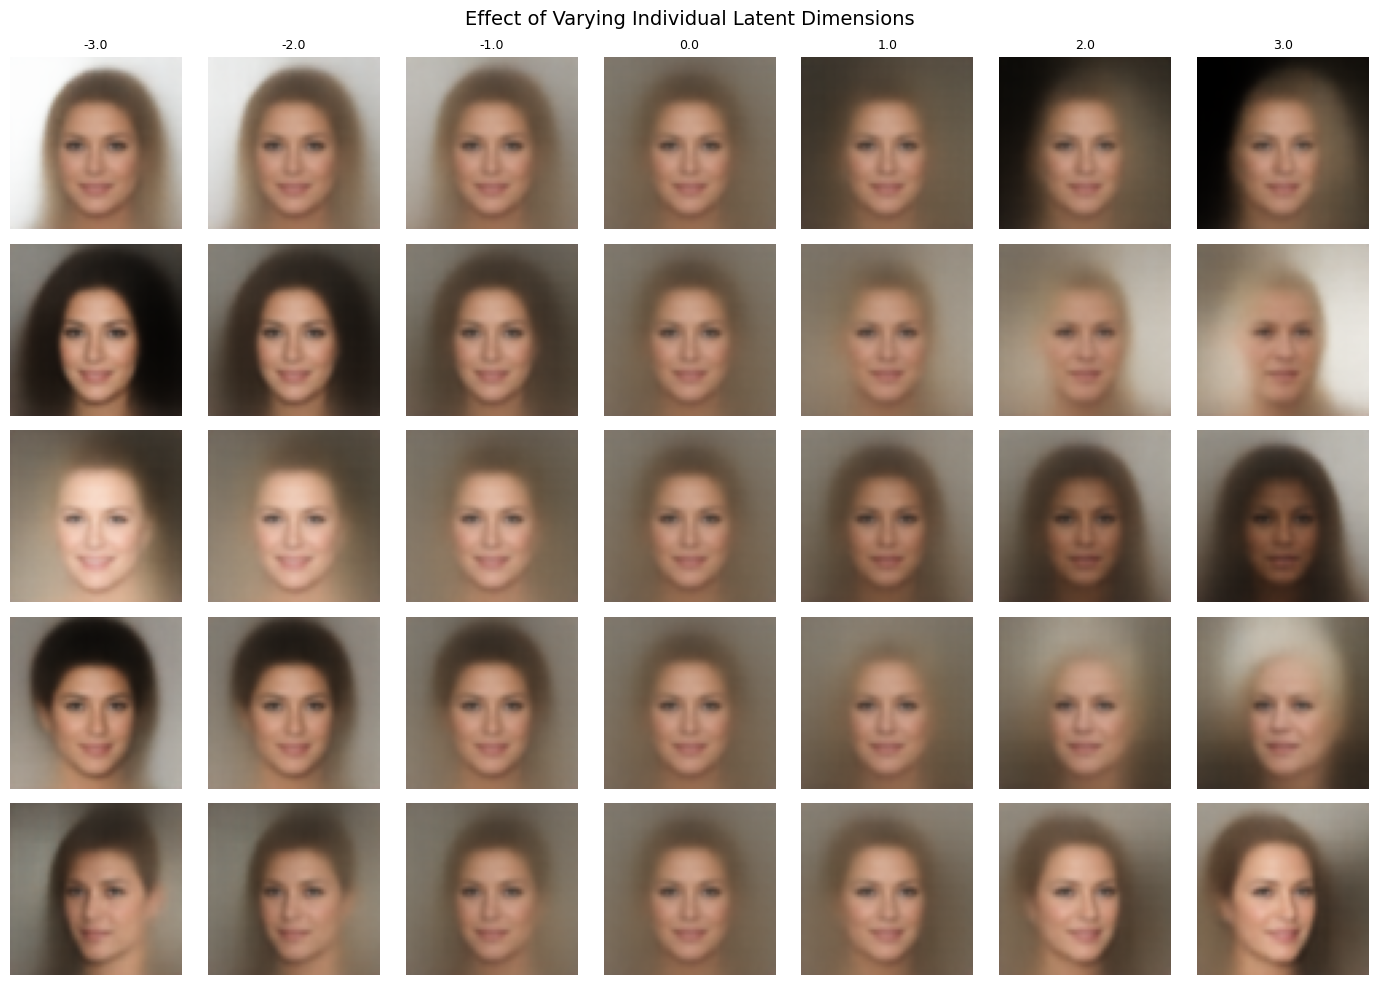

In [26]:
# Find dimensions with highest variance (likely encode meaningful features)
celeba_model.eval()

all_mus = []
with torch.no_grad():
    for i, (data, _) in enumerate(celeba_val_loader):
        if i >= 50:  # Just use subset for speed
            break
        data = data.to(device)
        mu, _ = celeba_model.encode(data)
        all_mus.append(mu.cpu())

all_mus = torch.cat(all_mus, dim=0)
variances = torch.var(all_mus, dim=0)
top_dims = torch.argsort(variances, descending=True)[:5]

print(f"Top 5 most variable latent dimensions: {top_dims.tolist()}")

# Visualize effect of varying these dimensions
fig, axes = plt.subplots(5, 7, figsize=(14, 10))

with torch.no_grad():
    base_z = torch.zeros(1, celeba_latent_dim).to(device)
    
    for dim_idx, dim in enumerate(top_dims):
        values = np.linspace(-3, 3, 7)
        
        for val_idx, val in enumerate(values):
            z = base_z.clone()
            z[0, dim] = val
            
            img = celeba_model.decode(z).cpu()
            ax = axes[dim_idx, val_idx]
            ax.imshow(img[0].permute(1, 2, 0).numpy())
            ax.axis('off')
            
            if val_idx == 0:
                ax.set_ylabel(f'Dim {dim}', fontsize=10)
            if dim_idx == 0:
                ax.set_title(f'{val:.1f}', fontsize=9)

plt.suptitle('Effect of Varying Individual Latent Dimensions', fontsize=14)
plt.tight_layout()
plt.show()

# High-variance dimensions seem to encode things like pose, lighting, and maybe age/gender,
# but it's not clean disentanglement - changing one dimension affects multiple attributes.
# Fine-grained features like specific facial expressions or accessories aren't really captured
# in individual dimensions. You'd need something like β-VAE to get better separation.

### Save CelebA Model

In [27]:
torch.save({
    'model_state_dict': celeba_model.state_dict(),
    'latent_dim': celeba_latent_dim,
    'train_losses': celeba_train_losses,
    'val_losses': celeba_val_losses
}, 'celeba_vae_final.pth')

print("CelebA model saved to 'celeba_vae_final.pth'")

CelebA model saved to 'celeba_vae_final.pth'


---
## Summary and Analysis

### Key Findings

**Task 1 - Convolutional Architecture:**
- Conv layers preserve spatial structure better than fully connected layers
- Training converged after 10 epochs:
  - Conv VAE: Loss 1824, KL 40 (better spatial coherence)
  - FC VAE: Loss 1867, KL 18 (higher loss despite lower KL - can't exploit locality)
- Direct visual comparison shows Conv generates recognizable objects while FC produces scattered pixels
- FC VAE treats neighboring pixels as independent, losing spatial relationships entirely
- Both models produce blurry images (inherent VAE limitation from BCE loss)

**Task 2 - Latent Space Interpolation:**
- Interpolation is smooth for color and overall shape (avg frame difference: 0.000615)
- Fine details wash out in the middle frames - edges and textures don't interpolate cleanly
- Some class pairs interpolate better than others (e.g., similar animals vs car to bird)

**Task 3 - CelebA:**
- Larger latent dim (256 vs 128) helps capture more facial variation
- Training results after 10 epochs: Loss 6290, KL 121
- Training was slower (~1.5 min/epoch vs ~30 sec for CIFAR-10) due to 64x64 images and larger dataset
- High-variance dimensions encode coarse attributes (pose, lighting) but not cleanly - changing one dimension affects multiple features
- Fine details missing: individual hairs, wrinkles, specific expressions
- Sampling at extreme latent values (high σ) produces distorted proportions

### What Didn't Work Well

- Generated images lack sharpness - this is inherent to the VAE objective (BCE reconstruction loss penalizes pixel-wise error, not perceptual quality)
- No way to control specific attributes (e.g., "make this face smile") without post-hoc latent manipulation
- FC VAE's loss was 2.4% worse than Conv (1867 vs 1824), showing spatial structure matters
- Training time: CIFAR-10 took ~20 min total (Conv + FC), CelebA took ~15 min for 10 epochs
- 10 epochs demonstrates concepts but isn't enough for high-quality generation - would need 30-50 for publishable results
- Interpolation blurs fine details in the middle frames
- Sampling outside training distribution (σ > 2) produces distorted outputs

### Architecture Notes

**Why conv beats fully connected:**
Conv layers exploit spatial locality through local receptive fields. A 3×3 conv kernel sees neighboring pixels as related, while FC layers treat pixel (0,0) and pixel (31,31) as equally distant. This is why Conv VAE (loss: 1824) outperformed FC VAE (loss: 1867) - spatial structure is fundamental to images.

Conv also has fewer parameters (6.3M vs 3.5M for FC, but Conv uses them more efficiently) and translation invariance (same features detected anywhere in image).

**CIFAR-10 vs CelebA:**
CelebA is more constrained (all faces, similar composition) so the model learns better structure. But higher resolution (64×64 vs 32×32) makes training slower and needs larger latent dim (256 vs 128). CIFAR-10 has 10 diverse classes which makes the latent space messier - harder to find smooth interpolation paths between, say, a truck and a bird.

### What Would Actually Improve This

- GANs or diffusion models for sharper images (but way more complex)
- β-VAE with higher β for better disentanglement (trades off reconstruction quality)
- Perceptual loss instead of pixel-wise BCE (more expensive to compute)
- VQ-VAE for discrete latents (different architecture entirely)

The core limitation is that VAEs optimize for reconstruction likelihood, not perceptual quality. That's why they're not the current state of the art for image generation, but they're still useful for learning structured latent representations.

---

**Training Summary:**
- Total runtime: ~35 minutes on M2 Max (MPS acceleration)
- CIFAR-10: Conv VAE (10 epochs, 1824 loss) + FC VAE (10 epochs, 1867 loss)
- CelebA: 10 epochs, 6290 loss, 121 KL
- Interpolation smoothness: 0.000615 avg frame difference
- All visualizations generated and embedded